In [2]:
import os, sys
import logging
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings('ignore')

path_splited = os.path.abspath('.').split('rsi_divergence_detector')[0]
PROJECT_PATH = os.path.join(path_splited, 'rsi_divergence_detector')
sys.path.append(PROJECT_PATH)
# Load the training data
# Replace 'training_data.csv' with your actual data file or DataFrame
df = pd.read_pickle(f'{PROJECT_PATH}/data/processed_data/training_data.pickle')
divergence_data = pd.read_pickle(f"{PROJECT_PATH}/data/processed_data/divergence_data.pickle")

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)


In [3]:
def get_device():
    """
    Selects the best available device: MPS (Apple GPU), CUDA (NVIDIA GPU), or CPU.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device for training.")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device for training.")
    else:
        device = torch.device("cpu")
        print("Using CPU for training.")
    return device


In [4]:
# Test dataframes sliced
df_5m = df[df.timeframe == '5m']
df_5m_filter = df_5m.loc[df_5m.index > '2024-11-20 00:30:00']
# df_5m_filter = df_5m_filter.loc[df_5m_filter.index < '2024-11-22 20:00:00']

df_total = df_5m_filter
df_divergence = divergence_data['15m']


In [5]:
df_total.head(3)

,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,willr,cci,atr,return_1,return_5,return_10,volatility_5,volatility_10,volume_change,volume_rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-20 00:35:00,1732062900000,92080.35,92260.0,92050.53,92260.00,50.34613,5m,54.149277,9.696354,-7.417105,...,-37.900067,13.364110,194.759931,0.001951,0.000873,0.001121,0.001268,0.001520,-0.287841,58.752716
2024-11-20 00:40:00,1732063200000,92259.99,92320.0,92233.69,92233.70,69.42001,5m,53.172138,15.807042,-2.772276,...,-44.181714,87.280919,187.013507,-0.000285,0.001365,0.001378,0.001193,0.001510,0.378855,62.958378
2024-11-20 00:45:00,1732063500000,92233.69,92260.0,92124.51,92130.93,55.29224,5m,49.419335,12.216304,0.225440,...,-68.727907,-21.628155,183.333257,-0.001114,-0.000337,-0.001948,0.001317,0.001361,-0.203511,62.781558


In [6]:
df_divergence.head(3)

,end_datetime,entry_datetime,entry_price,previous_peak_datetime,divergence,price_change,rsi_change,TP,SL,label,...,SL_percent,position,TP_vs_SL,TP_/_SL,profit,div_5m,div_15m,div_1h,div_4h,div_1d
start_datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 16:15:00,2017-08-17 18:00:00,2017-08-17 18:30:00,4287.69,2017-08-17 14:30:00,Bullish Divergence,5.18,6.47,4320.56,4218.68,False,...,1.61,False,0.476354,0.48,-69.01,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 01:15:00,2017-08-18 01:45:00,4231.61,2017-08-17 14:30:00,Bullish Divergence,37.98,10.29,4268.61,4134.61,True,...,2.29,False,0.381422,0.38,37.00,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 15:15:00,2017-08-18 15:45:00,4248.00,2017-08-17 14:30:00,Bullish Divergence,36.84,13.37,4314.89,4209.50,False,...,0.91,False,1.737402,1.74,-38.50,False,True,False,False,False


## Train LSTM

In [7]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset
from src.model.lstm_mixed import MixedLSTMModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming


In [ ]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
price_df = df[df['timeframe'] == '5m'].copy()
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


In [9]:

logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

2024-12-14 21:53:11,100 INFO Train events: 5812, Validation events: 1660, Test events: 831
2024-12-14 21:53:11,101 INFO Initializing datasets...


In [10]:

# Define device
device = get_device()
logger.info(f"Using device: {device}")

# Initialize Model
model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_hidden_dim": 256,
    "seq_num_layers": 2,
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 128,
    "num_classes": 2,
    "dropout": 0.1
}
model = MixedLSTMModel(**model_args)
logger.info(f"Model initialized with args: {model_args}")

# Generate model name
# Generate model name

lstm_model_name = model_naming(**model_args)
lstm_model_save_dir = os.path.join(PROJECT_PATH, 'model_data', 'mixed_lstm', lstm_model_name.split('.pt')[0])
os.makedirs(lstm_model_save_dir, exist_ok=True)
lstm_model_save_path = os.path.join(lstm_model_save_dir, lstm_model_name)


2024-12-14 21:53:13,886 INFO Using device: mps
2024-12-14 21:53:13,891 INFO Model initialized with args: {'seq_input_dim': 29, 'seq_hidden_dim': 256, 'seq_num_layers': 2, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 128, 'num_classes': 2, 'dropout': 0.1}


Using MPS device for training.


In [11]:
# Train the model
import warnings
warnings.filterwarnings('ignore')

logger.info("Starting training...")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=500,
    lr=1e-3,
    device=device,
    log_interval=10,
    save_path=lstm_model_save_path
)


2024-12-14 21:53:16,337 INFO Starting training...
2024-12-14 21:53:34,495 INFO Epoch [1/500] - Train Loss: 4.5403, Train Acc: 0.6796 - Val Loss: 0.6170, Val Acc: 0.7036 - Time cost: 17.68
2024-12-14 21:53:34,505 INFO Best model saved with Val Acc: 0.7036
2024-12-14 21:53:51,699 INFO Epoch [2/500] - Train Loss: 0.5855, Train Acc: 0.7536 - Val Loss: 0.6286, Val Acc: 0.7036 - Time cost: 17.19
2024-12-14 21:54:09,140 INFO Epoch [3/500] - Train Loss: 0.5663, Train Acc: 0.7579 - Val Loss: 0.6134, Val Acc: 0.7036 - Time cost: 17.44
2024-12-14 21:54:26,538 INFO Epoch [4/500] - Train Loss: 0.5580, Train Acc: 0.7576 - Val Loss: 0.6186, Val Acc: 0.7036 - Time cost: 17.40
2024-12-14 21:54:43,902 INFO Epoch [5/500] - Train Loss: 0.5578, Train Acc: 0.7576 - Val Loss: 0.6146, Val Acc: 0.7036 - Time cost: 17.36
2024-12-14 21:55:02,089 INFO Epoch [6/500] - Train Loss: 0.5562, Train Acc: 0.7577 - Val Loss: 0.6156, Val Acc: 0.7036 - Time cost: 18.19
2024-12-14 21:55:19,863 INFO Epoch [7/500] - Train Loss

2024-12-14 22:09:28,262 INFO Loading the best Transformer model for testing...
2024-12-14 22:09:28,273 INFO Evaluating on test set...
2024-12-14 22:09:29,401 INFO =================Test Metrics===================
2024-12-14 22:09:29,401 INFO loss: 0.571584
2024-12-14 22:09:29,402 INFO accuracy: 0.742479
2024-12-14 22:09:29,402 INFO precision: 0.0
2024-12-14 22:09:29,402 INFO recall: 0.0
2024-12-14 22:09:29,403 INFO f1_score: 0.0
2024-12-14 22:09:29,403 INFO confusion_matrix: [[617   0]
 [214   0]]
2024-12-14 22:09:29,404 INFO Metrics saved to /Users/shawn/Documents/personal/rsi_divergence_detector/model_data/mixed_lstm/sid29_shd256_snl2_nid6_mhd128_nc2_d0.1000/metrics.pkl
2024-12-14 22:09:29,404 INFO Plotting training results for the Transformer model...


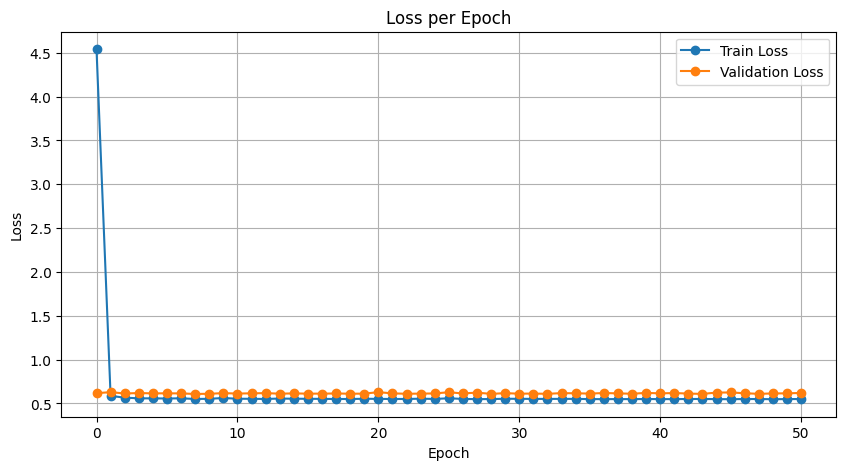

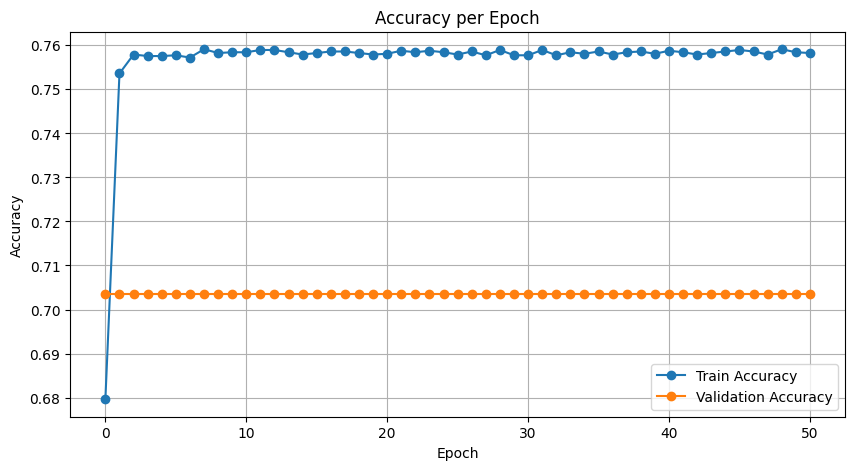

In [12]:
# Load the best Transformer model
logger.info("Loading the best Transformer model for testing...")
model.load_state_dict(torch.load(lstm_model_save_path, map_location=device))

# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader, device)
logger.info(f"=================Test Metrics===================")
for key, value in test_metrics.items():
    if type(value) in [float]:
        logger.info(f"{key}: {value:4f}")
    else:
        logger.info(f"{key}: {value}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1_score': test_metrics['f1_score'],
    'test_confusion_matrix': test_metrics['confusion_matrix']
}
metrics_path = os.path.join(lstm_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results for the Transformer model...")
plot_save_dir = os.path.join(lstm_model_save_dir, 'plots')
os.makedirs(plot_save_dir, exist_ok=True)
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=plot_save_dir)

## Train Transformer

In [13]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset, create_divergence_sequence
from src.model.transformer import TransformerMixedModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming
from sklearn.utils import class_weight
import numpy as np


In [ ]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
price_df = df[df['timeframe'] == '5m'].copy()
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

2024-12-14 22:09:40,784 INFO Train events: 5812, Validation events: 1660, Test events: 831
2024-12-14 22:09:40,785 INFO Initializing datasets...


In [15]:
device = get_device()
logger.info(f"Using device: {device}")

# Initialize Transformer Model
transformer_model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_model_dim": 256,          # You can adjust this as needed
    "seq_num_heads": 8,            # Number of attention heads
    "seq_num_layers": 8,           # Number of Transformer layers
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 256,
    "num_classes": 2,
    "dropout": 0.2,
    "max_len": 500                 # Maximum sequence length
}


transformer_model = TransformerMixedModel(**transformer_model_args)
logger.info(f"Transformer Model initialized with args: {transformer_model_args}")

# Generate model name
transformer_model_name = model_naming(**transformer_model_args)
transformer_model_save_dir = os.path.join(PROJECT_PATH, 'model_data', 'transformer_mixed', transformer_model_name.split('.pt')[0])
os.makedirs(transformer_model_save_dir, exist_ok=True)
transformer_model_save_path = os.path.join(transformer_model_save_dir, transformer_model_name)

# Calculate class weights for imbalanced loss
classes = np.unique(divergence_df_train['label'])
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=divergence_df_train['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
logger.info(f"Class weights: {class_weights}")

2024-12-14 22:09:59,070 INFO Using device: mps
2024-12-14 22:09:59,091 INFO Transformer Model initialized with args: {'seq_input_dim': 29, 'seq_model_dim': 256, 'seq_num_heads': 8, 'seq_num_layers': 8, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 256, 'num_classes': 2, 'dropout': 0.2, 'max_len': 500}
2024-12-14 22:09:59,195 INFO Class weights: tensor([0.6570, 2.0922], device='mps:0')


Using MPS device for training.


In [16]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(transformer_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Train the Transformer model
logger.info("Starting training of the Transformer model...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=transformer_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=500,
    lr=1e-3,
    device=device,
    log_interval=10,
    save_path=transformer_model_save_path,
    patience=50
)



2024-12-14 22:10:03,275 INFO Starting training of the Transformer model...
2024-12-14 22:11:08,241 INFO Epoch [1/500] - Train Loss: 147.3986, Train Acc: 0.4902 - Val Loss: 39.1188, Val Acc: 0.7036 - Time cost: 64.93
2024-12-14 22:11:08,323 INFO Best model saved with Val Acc: 0.7036
2024-12-14 22:12:15,425 INFO Epoch [2/500] - Train Loss: 62.5454, Train Acc: 0.5167 - Val Loss: 39.9143, Val Acc: 0.2964 - Time cost: 67.10
2024-12-14 22:13:23,977 INFO Epoch [3/500] - Train Loss: 44.3408, Train Acc: 0.4911 - Val Loss: 120.4989, Val Acc: 0.2964 - Time cost: 68.55
2024-12-14 22:14:33,351 INFO Epoch [4/500] - Train Loss: 23.5247, Train Acc: 0.5050 - Val Loss: 13.4170, Val Acc: 0.2964 - Time cost: 69.37
2024-12-14 22:15:40,179 INFO Epoch [5/500] - Train Loss: 34.3213, Train Acc: 0.5105 - Val Loss: 83.9954, Val Acc: 0.2964 - Time cost: 66.83
2024-12-14 22:16:43,913 INFO Epoch [6/500] - Train Loss: 30.7037, Train Acc: 0.5057 - Val Loss: 137.8129, Val Acc: 0.2964 - Time cost: 63.73
2024-12-14 22:1

KeyboardInterrupt: 

In [19]:
checkpoint.keys()

odict_keys(['layer_norm.weight', 'layer_norm.bias', 'input_proj.weight', 'input_proj.bias', 'pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.l

In [24]:
# Load the saved model
checkpoint = torch.load(transformer_model_save_path)
# transformer_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1

# Optionally, load the scheduler state if it was used previously
if 'scheduler_state_dict' in checkpoint:
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Update the logger to indicate resuming training
# logger.info(f"Resuming training from epoch {start_epoch}...")

# Continue training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=transformer_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=1000,  # Total epochs, will pick up from `start_epoch`
    # start_epoch=start_epoch,  # Pass the starting epoch
    lr=1e-3,  # Ensure this is consistent with the optimizer settings
    device=device,
    log_interval=10,
    save_path=transformer_model_save_path,
    patience=100
)


2024-12-14 23:31:47,636 INFO Epoch [1/1000] - Train Loss: 1.0979, Train Acc: 0.5848 - Val Loss: 1.5632, Val Acc: 0.7048 - Time cost: 66.02
2024-12-14 23:31:47,700 INFO Best model saved with Val Acc: 0.7048
2024-12-14 23:32:53,798 INFO Epoch [2/1000] - Train Loss: 3.1048, Train Acc: 0.5530 - Val Loss: 1.6735, Val Acc: 0.3428 - Time cost: 66.10
2024-12-14 23:33:59,890 INFO Epoch [3/1000] - Train Loss: 3.0015, Train Acc: 0.5231 - Val Loss: 1.7153, Val Acc: 0.7048 - Time cost: 66.09
2024-12-14 23:35:05,331 INFO Epoch [4/1000] - Train Loss: 4.5357, Train Acc: 0.5277 - Val Loss: 1.2850, Val Acc: 0.7048 - Time cost: 65.44
2024-12-14 23:36:10,092 INFO Epoch [5/1000] - Train Loss: 2.5130, Train Acc: 0.5483 - Val Loss: 0.6418, Val Acc: 0.7030 - Time cost: 64.76
2024-12-14 23:37:13,889 INFO Epoch [6/1000] - Train Loss: 1.8722, Train Acc: 0.5607 - Val Loss: 0.8983, Val Acc: 0.6886 - Time cost: 63.80
2024-12-14 23:38:17,341 INFO Epoch [7/1000] - Train Loss: 1.8149, Train Acc: 0.5571 - Val Loss: 6.7

2024-12-15 12:33:55,831 INFO Loading the best Transformer model for testing...
2024-12-15 12:33:55,916 INFO Evaluating on test set...
2024-12-15 12:33:59,737 INFO =================Test Metrics===================
2024-12-15 12:33:59,738 INFO loss: 0.622137
2024-12-15 12:33:59,739 INFO accuracy: 0.742479
2024-12-15 12:33:59,739 INFO precision: 0.5
2024-12-15 12:33:59,740 INFO recall: 0.004672897196261682
2024-12-15 12:33:59,740 INFO f1_score: 0.009259259259259259
2024-12-15 12:33:59,741 INFO confusion_matrix: [[616   1]
 [213   1]]
2024-12-15 12:33:59,744 INFO Metrics saved to /Users/shawn/Documents/personal/rsi_divergence_detector/model_data/transformer_mixed/sid29_smd256_snh8_snl8_nid6_mhd256_nc2_d0.2000_ml500/metrics.pkl
2024-12-15 12:33:59,744 INFO Plotting training results for the Transformer model...


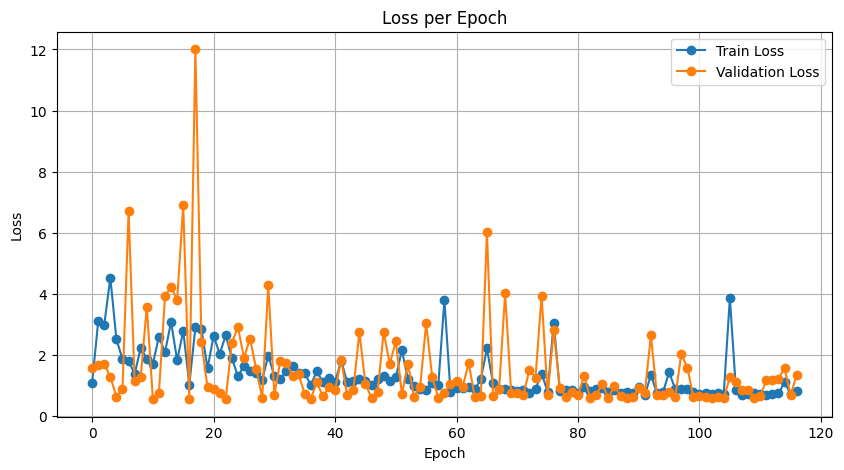

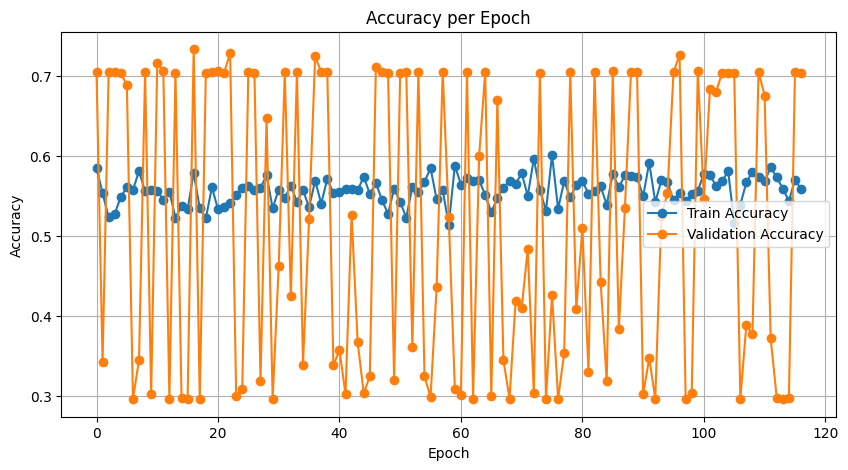

In [25]:

# Load the best Transformer model
logger.info("Loading the best Transformer model for testing...")
transformer_model.load_state_dict(torch.load(transformer_model_save_path, map_location=device))

# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
test_metrics = evaluate_model(transformer_model, test_loader, device)
logger.info(f"=================Test Metrics===================")
for key, value in test_metrics.items():
    if type(value) in [float]:
        logger.info(f"{key}: {value:4f}")
    else:
        logger.info(f"{key}: {value}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1_score': test_metrics['f1_score'],
    'test_confusion_matrix': test_metrics['confusion_matrix']
}
metrics_path = os.path.join(transformer_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results for the Transformer model...")
plot_save_dir = os.path.join(transformer_model_save_dir, 'plots')
os.makedirs(plot_save_dir, exist_ok=True)
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=plot_save_dir)

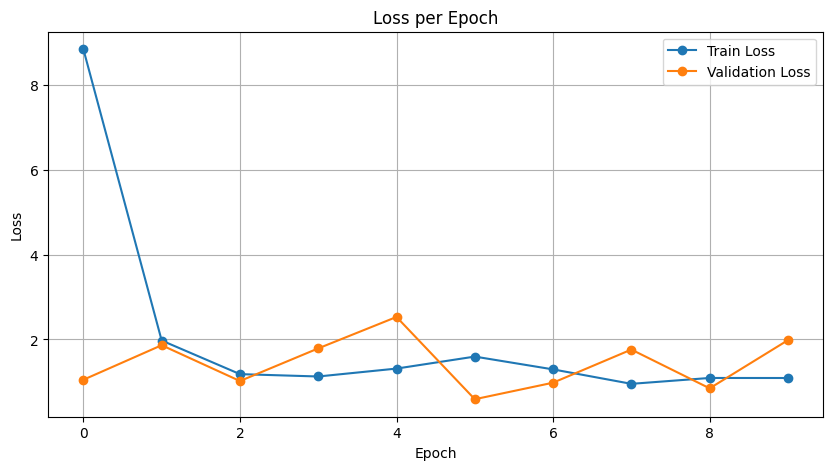

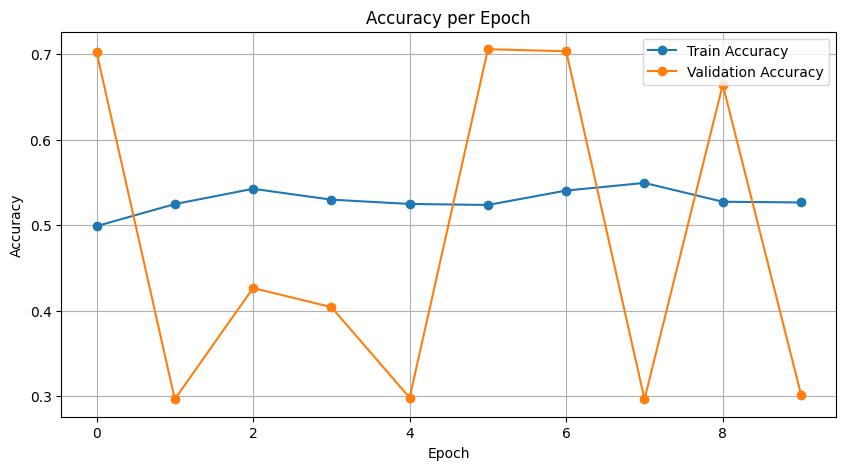

In [30]:

def plot_results_combined(train_losses, val_losses, train_accuracies, val_accuracies, outdir='plots'):
    """
    Plot training and validation loss and accuracy in a single figure (stacked vertically).
    
    Parameters:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    - train_accuracies: List of training accuracies per epoch.
    - val_accuracies: List of validation accuracies per epoch.
    - outdir: Directory to save the plots.
    """
    os.makedirs(outdir, exist_ok=True)
    
    # Create a combined plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot Loss
    axs[0].plot(train_losses, label='Train Loss', marker='o', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', marker='o', color='orange')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot Accuracy
    axs[1].plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
    axs[1].plot(val_accuracies, label='Validation Accuracy', marker='o', color='red')
    axs[1].set_title('Accuracy per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # Save the combined plot
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'combined_plot.png'))
    plt.show()

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=plot_save_dir)


In [28]:
checkpoint


OrderedDict([('layer_norm.weight',
              tensor([1.0017, 1.0059, 1.0067, 1.0074, 0.9929, 0.9912, 0.9925, 0.9911, 1.0048,
                      0.9994, 1.0058, 0.9935, 1.0050, 1.0044, 0.9934, 1.0025, 0.9975, 1.0034,
                      0.9988, 1.0006, 1.0045, 0.9928, 0.9996, 1.0057, 1.0062, 0.9960, 1.0060,
                      1.0055, 0.9929, 1.0066, 0.9941, 1.0054, 1.0027, 1.0050, 1.0047, 0.9950,
                      1.0049, 0.9920, 1.0041, 0.9925, 1.0049, 0.9952, 0.9932, 0.9933, 0.9934,
                      0.9912, 0.9931, 1.0003, 1.0071, 0.9938, 1.0034, 1.0058, 0.9929, 0.9946,
                      0.9959, 1.0016, 1.0041, 0.9940, 0.9934, 1.0078, 1.0056, 0.9946, 0.9938,
                      1.0063, 0.9916, 0.9931, 0.9938, 1.0085, 0.9922, 1.0051, 1.0065, 1.0068,
                      1.0055, 1.0055, 0.9937, 1.0057, 1.0018, 0.9939, 0.9995, 0.9939, 0.9997,
                      1.0041, 1.0008, 1.0000, 1.0048, 0.9954, 1.0046, 1.0084, 1.0052, 0.9920,
                      1.0